In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def load_model():
    nodes=np.loadtxt(r'F:\python_FEM\plane\node.txt')
    elems=np.loadtxt(r'F:\python_FEM\plane\elem.txt')
    elems=np.array(elems,dtype=int)
    fix_support=np.loadtxt(r'F:\python_FEM\plane\fixsupport.txt')
    fix_support=np.array(fix_support[:,0],dtype=int)
    force=np.loadtxt(r'F:\python_FEM\plane\force.txt')
    force=np.array(force[:,0],dtype=int)
    return nodes, elems, fix_support, force

In [3]:
nodes,elems,fix_support,force=load_model()

In [4]:
def plot_model(nodes,elems,fix_support,
               force,show_node=True,show_elem=True,show_support=True,show_force=True):
    fig1,ax1=plt.subplots()
    ax1.set_aspect('equal')
    if show_node:
        ax1.scatter(nodes[:,1],nodes[:,2],color='g')
    if show_elem:
        for elem in elems:
            node_ids = elem[1:5]
            node_ids = np.array(node_ids, dtype=int)
            coord_x = list(nodes[node_ids-1,1])
            coord_y = list(nodes[node_ids-1,2])
            plt.plot(coord_x+[coord_x[0],],coord_y+[coord_y[0],],color='k')
    if show_support:
        support_x=nodes[fix_support-1,1]
        support_y=nodes[fix_support-1,2]
        ax1.scatter(support_x,support_y,50,color='r')
    if show_force:
        force_x=nodes[force-1,1]
        force_y=nodes[force-1,2]
        ax1.scatter(force_x,force_y,50,color='b')
    plt.show()

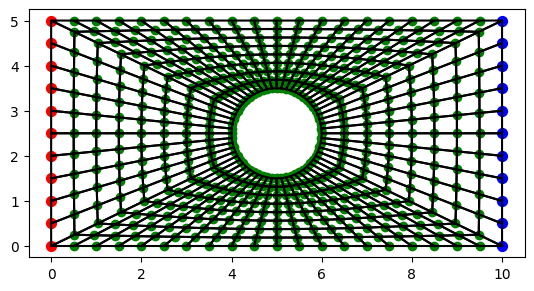

In [5]:
plot_model(nodes,elems,fix_support,force,show_node=True,show_elem=True)

In [6]:
def create_d_matrix(E, nu):
    # 确保泊松比在合理范围内
    if nu >= 1 or nu <= -1:
        raise ValueError("泊松比 nu 必须在 (-1, 1) 范围内")
    
    # 计算 D 矩阵
    d_matrix = (E / (1 - nu ** 2)) * np.array([[1, nu, 0],
                                                [nu, 1, 0],
                                                [0, 0, (1 - nu) / 2]])
    
    return d_matrix

In [7]:
D=create_d_matrix(2e10,0.3)

In [8]:
def shape_function(xi, eta):
    shape = np.zeros(4)
    deriv = np.zeros((2,4))
    shape[0]=(1-xi)*(1-eta)/4
    shape[1]=(1+xi)*(1-eta)/4
    shape[2]=(1+xi)*(1+eta)/4
    shape[3]=(1-xi)*(1+eta)/4
    
    deriv[0,0:4]=eta-1,1-eta,1+eta,-eta-1
    deriv[1,0:4]=xi-1,-xi-1,1+xi,1-xi
    deriv = deriv*0.25
    return shape, deriv #形函数和对应形函数的导数

In [9]:
def gauss_quadrature():
    """高斯积分点和权重"""
    xi = np.array([-1 / np.sqrt(3), 1 / np.sqrt(3), 1 / np.sqrt(3), -1 / np.sqrt(3)])
    eta = np.array([-1 / np.sqrt(3), -1 / np.sqrt(3), 1 / np.sqrt(3), 1 / np.sqrt(3)])
    weight = np.array([1, 1, 1, 1])
    return xi, eta, weight

In [37]:
def compute_jacobian(deriv, coord):
    """计算雅可比矩阵及其行列式"""
    jacobian = deriv.dot(coord.T)
    det_j = np.linalg.det(jacobian)
    # 计算导数变换
    XY_deriv = np.linalg.inv(jacobian).dot(deriv)
    return jacobian, det_j, XY_deriv 

In [11]:
def compute_B(deriv):
    """计算B矩阵"""
    B = np.zeros((3, 8))
    B[0, 0:8:2] = deriv[0, 0:4]
    B[1, 1:9:2] = deriv[1, 0:4]
    B[2, 0:8:2] = deriv[1, 0:4]
    B[2, 1:9:2] = deriv[0, 0:4]
    return B

In [38]:
def compute_element_stiffness(nodes, elem, D):
    """计算单元刚度矩阵"""
    coord_x = nodes[elem[1:5] - 1, 1]  # 提取 x 坐标
    coord_y = nodes[elem[1:5] - 1, 2]  # 提取 y 坐标
    coord = np.array((coord_x, coord_y))

    xi, eta, weight = gauss_quadrature()
    K_e = np.zeros((8, 8))

    for igp in range(4):
        shape, deriv = shape_function(xi[igp], eta[igp])  # 计算形状函数及其导数
        jacobian, det_j, XY_deriv = compute_jacobian(deriv, coord)  # 获取导数变换
        B = compute_B(XY_deriv)
        dvol = weight[igp] * det_j  # 体积元素
        dummy = B.T @ D @ B  # 当前积分点的刚度矩阵
        K_e += dummy * dvol  # 累加至单元刚度矩阵

    return K_e

In [39]:
def assemble_global_stiffness(nodes, elems, D):
    """组装全局刚度矩阵"""
    node_num = nodes.shape[0]
    dofs = 2
    global_stiffness = np.zeros((node_num * dofs, node_num * dofs))  # 全局刚度矩阵大小

    for elem in elems:
        K_e = compute_element_stiffness(nodes, elem, D)  # 计算单元刚度矩阵
        L = np.zeros((8, node_num * dofs))  # 映射矩阵
        node_id = elem[1:5]

        for ni in range(4):
            L[ni * 2, (node_id[ni] - 1) * 2] = 1
            L[ni * 2 + 1, (node_id[ni] - 1) * 2 + 1] = 1

        K_e2g = L.T @ K_e @ L  # 转换为全局坐标系
        global_stiffness += K_e2g  # 更新全局刚度矩阵

    return global_stiffness

In [40]:
global_stiffness = assemble_global_stiffness(nodes, elems, D)

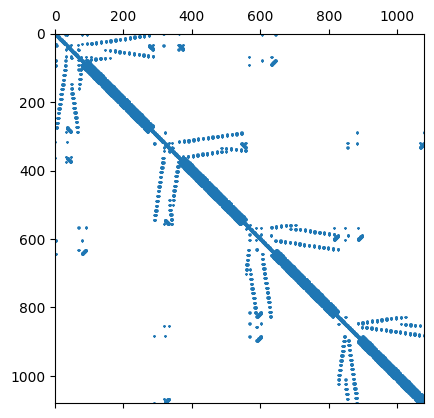

In [41]:
plt.spy(global_stiffness,marker='*',markersize=1)
plt.show()

In [42]:
#单元自由度问题，四节点单元
#节点1，Ux1和Uy1
#Ux1,Uy1,Ux2,Uy2,Ux3,Uy3,Ux4,Uy4
#荷载：100N/m 长度5m 合力500N
#中间节点受力=单元长度*100N/m
#两端节点受力=（单元长度*100N/m）/2
#单元长度=0.5m
node_num = nodes.shape[0]
dofs = 2
def load():
    f = np.zeros(node_num*dofs)
    for fid in force:
        pos_x=(fid-1)*2
        f[pos_x]=0.5*100
        if fid==168 or fid==415:
            f[pos_x]=0.5*100/2
    return f

In [43]:
global_force=load()

In [44]:
#施加固定位移的约束
def apply_support():
    for fix_id in fix_support:
        pos_x=(fix_id-1)*2
        #global_stiffness[pos_x,:]=0
        #global_stiffness[:,pos_x]=0
        global_stiffness[pos_x,pos_x]*=1e5
        if fix_id==280:
            pos_y=(fix_id-1)*2+1
            global_stiffness[pos_y,pos_y]*=1e5
apply_support()

In [45]:
#计算Ku=F
nodal_disp = np.linalg.solve(global_stiffness,global_force)

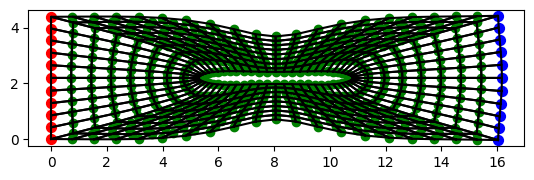

In [46]:
#更新节点坐标信息
ux_all_nodes=nodal_disp[0:nodal_disp.shape[0]:2]
uy_all_nodes=nodal_disp[1:nodal_disp.shape[0]:2]
new_nodes=np.zeros_like(nodes)
new_nodes[:,0]=nodes[:,0]
new_nodes[:,1]=nodes[:,1]+ux_all_nodes[:]*1e8
new_nodes[:,2]=nodes[:,2]+uy_all_nodes[:]*1e8
plot_model(new_nodes,elems,fix_support,force,show_node=True,show_elem=True)